In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import FuncFormatter as ff
plt.style.use('fivethirtyeight')

import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

from datetime import datetime, timedelta

In [2]:
#creates connection to mongodb
client = pymongo.MongoClient()
db = client.tweeter

In [3]:
bernie_coll = db.bernie_tweets
joe_coll = db.joe_tweets
pete_coll = db.pete_tweets
warren_coll = db.warren_tweets
amy_coll = db.amy_tweets

In [4]:
#retrieved data from mongo into a dataframe
bernie_df = pd.DataFrame(list(bernie_coll.find()))
joe_df = pd.DataFrame(list(joe_coll.find()))
pete_df = pd.DataFrame(list(pete_coll.find()))
warren_df = pd.DataFrame(list(warren_coll.find()))
amy_df = pd.DataFrame(list(amy_coll.find()))

In [ ]:
# b_df = bernie_df[~bernie_df['text'].isnull()]

In [ ]:
# df = b_df.set_index('date')
# df.index = pd.to_datetime(df.index)
# df['year'] = df.index.year
# df['month'] = df.index.month
# df['wk_name'] = df.index.weekday_name

In [11]:
sentiment_analyser(bernie_df)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: 3 columns passed, passed data had 2 columns

In [16]:
def sentiment_analyser(df):
    df = df[~df['text'].isnull()]
    df.loc[:,'text'] = df.loc[:,'text'].apply(lambda x: remove_url(x))
    n_df = df[~df['text'].isnull()]
    
    sentiment_objects = [TextBlob(tweet) for tweet in n_df['text']]
    # Create list of polarity valuesx and tweet text
    sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
    # Create dataframe containing the polarity value and tweet text
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

    sent_df = n_df.merge(sentiment_df, left_on='text', right_on='tweet')
    
    output_df = sent_df.set_index('date')
    output_df.index = pd.to_datetime(output_df.index)
    output_df['year'] = output_df.index.year
    output_df['month'] = output_df.index.month
    output_df['day'] = output_df.index.day
    output_df['wk_name'] = output_df.index.weekday_name
    
    return output_df

In [17]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [19]:
def plot_sentiment(df):
    #plot data
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot histogram of the polarity values
    sentiment_df.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                            0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                 ax=ax,
                 color="purple")

    plt.title(title)
    return plt.show()

In [8]:
def tweets_per_day(df):
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    result = df['wk_name'].value_counts().reindex(cats).reset_index().rename(columns={'index':'weekday', 'wk_name':'num_tweets'})
    return result

In [20]:
bernie_sentiment = sentiment_analyser(bernie_df)
joe_sentiment = sentiment_analyser(joe_df)
pete_sentiment = sentiment_analyser(pete_df)
warren_sentiment = sentiment_analyser(warren_df)
amy_sentiment = sentiment_analyser(amy_df)

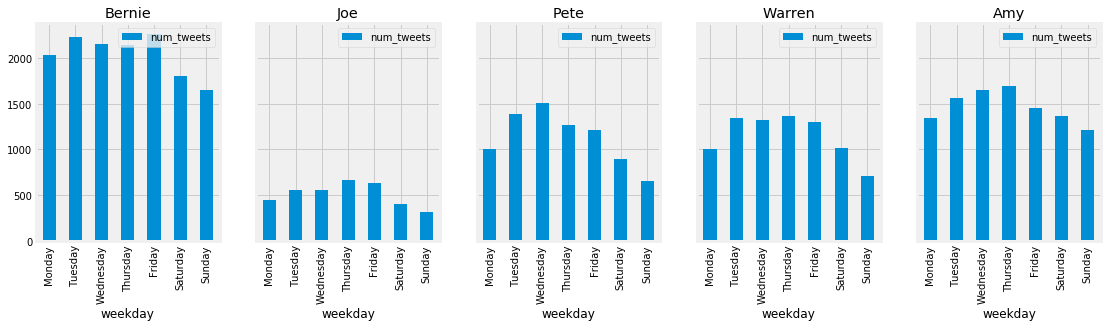

In [21]:
fig, ax = plt.subplots(1,5, figsize=(17,4), sharey=True, sharex=True)
tweets_per_day(bernie_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[0], title='Bernie')
tweets_per_day(joe_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[1], title='Joe')
tweets_per_day(pete_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[2], title='Pete')
tweets_per_day(warren_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[3], title='Warren')
tweets_per_day(amy_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[4], title='Amy')
plt.legend()
plt.show()

In [22]:
def polarity_bydate(df, yr=None, mm=None, dd=None):
    '''
    creates a polarity graph based on dates selected. 
    '''
    try:
        if yr!=None and mm!=None and dd!=None:
            query = df[(df['year']==yr)&(df['month']==mm)&(df['day']==dd)]['polarity']
        elif yr!=None and mm!=None:
            query = df[(df['year']==yr)&(df['month']==mm)]['polarity']
        elif mm!=None and dd!=None:
            query = df[(df['month']==mm)&(df['day']==mm)]['polarity']
        elif yr!=None and dd!=None:
            query = df[(df['year']==yr)&(df['day']==mm)]['polarity']
        elif yr!=None:
            query = df[df['year']==yr]['polarity']
        elif mm!=None:
            query = df[df['month']==mm]['polarity']    
        elif dd!=None:
            query = df[df['day']==mm]['polarity']   

        #plot data
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot histogram of the polarity values
        query.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                                0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                     ax=ax,
                     color="purple")

        plt.title("Sentiments from Tweets from Bernie")
        return plt.show()
    
    except:
        return print('please provide a year, month, or day to filter by')

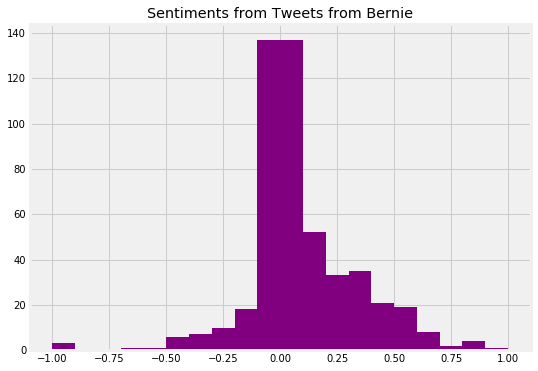

In [23]:
polarity_bydate(df=bernie_sentiment, yr=2020, mm=1)

In [ ]:
sentiment_objects = [TextBlob(tweet) for tweet in b_df['text']]

In [ ]:
# Create list of polarity valuesx and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [ ]:
# Create dataframe containing the polarity value and tweet text
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                        0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets from Bernie")
plt.show()

In [ ]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets from Bernie")
plt.show()

In [ ]:
sentiment_df.sort_values(by='polarity')

In [ ]:
a = sentiment_df[(sentiment_df['polarity']< 0)&(sentiment_df['polarity']< 0.05)]

In [ ]:
# bern_df = b_df.set_index('date')

In [ ]:
# bern_df.index = pd.to_datetime(bern_df.index)

In [ ]:
# bern_df.head()

In [ ]:
# bern_df['year'] = bern_df.index.year
# bern_df['month'] = bern_df.index.month
# bern_df['wk_name'] = bern_df.index.weekday_name

In [ ]:
# [TextBlob(tweet) for tweet in bern_df['text']]

In [26]:
def tweet_mention_hash_plot(df, rate='M'):
    df.resample(rate)[['text', 'mentions', 'hashtags']].count().plot()
    return plt.show()

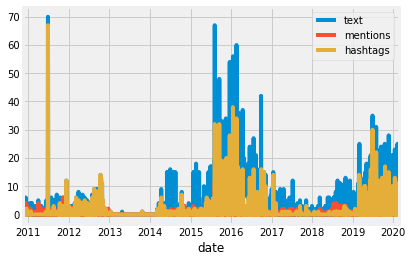

In [27]:
tweet_mention_hash_plot(bernie_sentiment, 'D')

In [ ]:
# def polyplot(df):
#     n_df = df[~df['text'].isnull()]
#     show_df = n_df.set_index('date')
#     show_df.index = pd.to_datetime(show_df.index)

#     show_df.resample('M')['text'].count().plot()
#     show_df.resample('M')['mentions'].count().plot()
#     return plt.show()

In [ ]:
# polyplot(joe_df)

In [28]:
def retweet_fav_reply_plot(df, title, rate='M', asof=None, figsize=(12,8)):
    if asof is not None:
        df = df[df.index > (asof - timedelta(days=7))]
    
    fig, ax = plt.subplots(figsize=figsize)
    df.resample(rate)[['retweets', 'favorites', 'replies']].sum().plot(ax=ax)
    ax.get_yaxis().set_major_formatter(ff(lambda x, p: format(int(x), ',')))
    ax.legend(fancybox=True, frameon=True, framealpha=1, shadow=True, borderpad=1, title='Twitter Interaction')
    plt.title(title)
    return plt.show()

In [29]:
def data_filter(df, asof=None):
    if asof is not None:
        df = df[df.index > (asof - timedelta(days=7))]
    
    result = df[['text', 'polarity', 'wk_name','favorites']]
    return result

In [30]:
bern_ann= pd.to_datetime('2/19/2019')
joe_ann= pd.to_datetime('4/25/2019')
pete_ann= pd.to_datetime('1/23/2019')
warren_ann= pd.to_datetime('12/31/2018')
amy_ann= pd.to_datetime('2/10/2019')

In [ ]:
def polyplot(df, rate='M'):
    n_df = df[~df['text'].isnull()]
    show_df = n_df.set_index('date')
    show_df.index = pd.to_datetime(show_df.index)
    return show_df.resample(rate)['text'].count()

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
polyplot(bernie_df).plot()
polyplot(joe_df).plot()
polyplot(pete_df).plot()
polyplot(warren_df).plot()
polyplot(amy_df).plot()
labels = ['Bernie Sanders', 'Joe Biden', 'Pete Buttigieg', 'Elizabeth Warren ', 'Amy Klobuchar']
plt.legend(labels)
plt.title('Number of Tweets of DNC Presidential Candidates Tweeter Account')
plt.show()

In [ ]:
data = pd.concat([polyplot(bernie_df, rate='D'),polyplot(joe_df, rate='D'), 
                  polyplot(pete_df, rate='D'), polyplot(warren_df, rate='D'),
                  polyplot(amy_df, rate='D')], axis=1)

cols = ['bernie', 'joe', 'pete', 'warren', 'amy']
data.columns = cols

In [ ]:
data.head()

In [31]:
def plot_trend(x, y):
    title = "{} Tweets Trends".format(y.capitalize())
    fig=px.line(data, x=x, y=y, title=title)
    return fig.show()

In [32]:
plot_trend(data.index, 'warren')
plot_trend(data.index, 'joe')

NameError: name 'data' is not defined

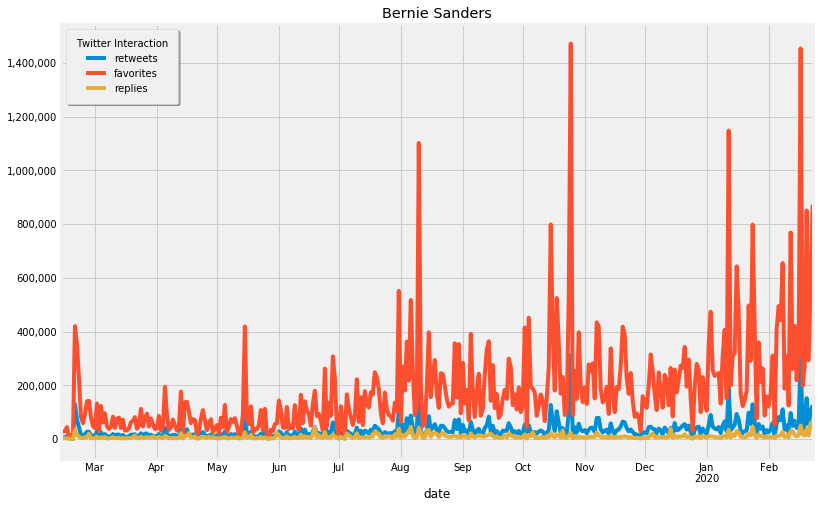

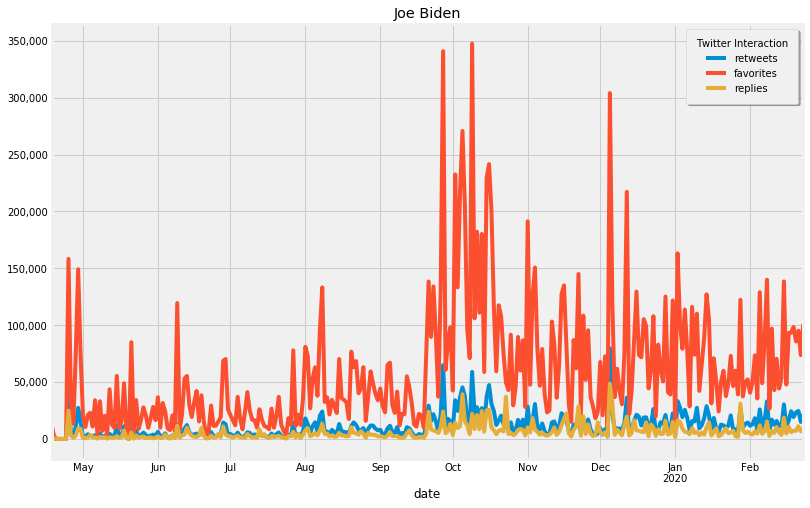

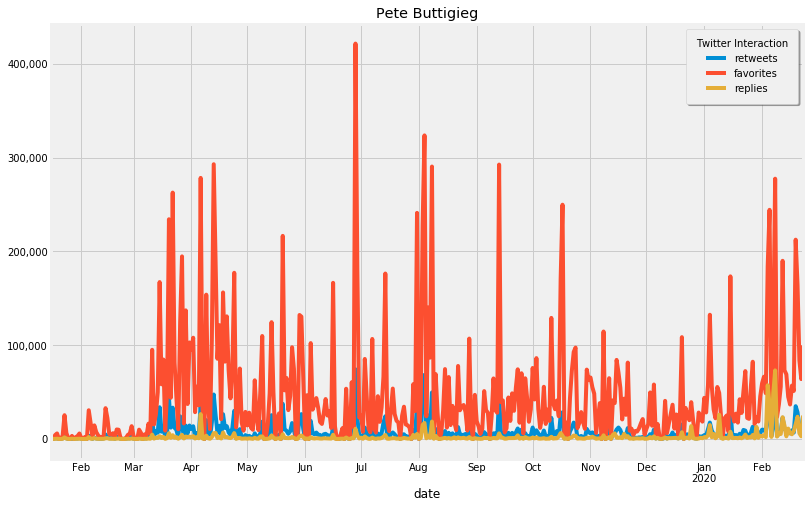

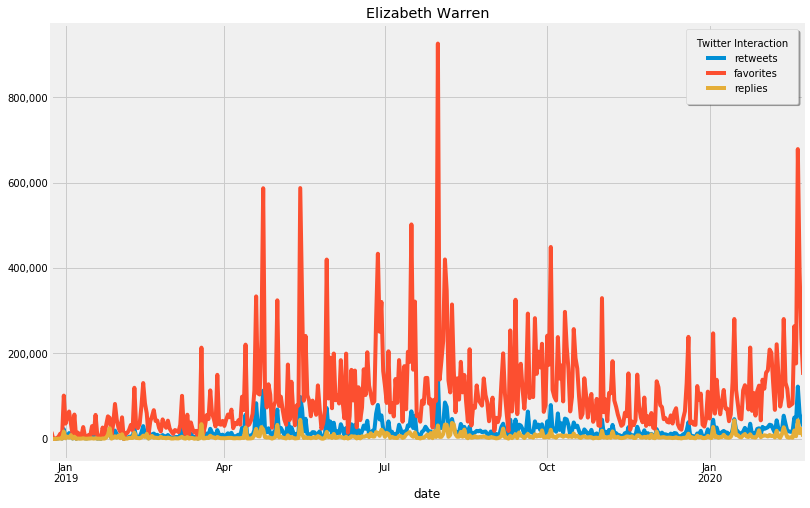

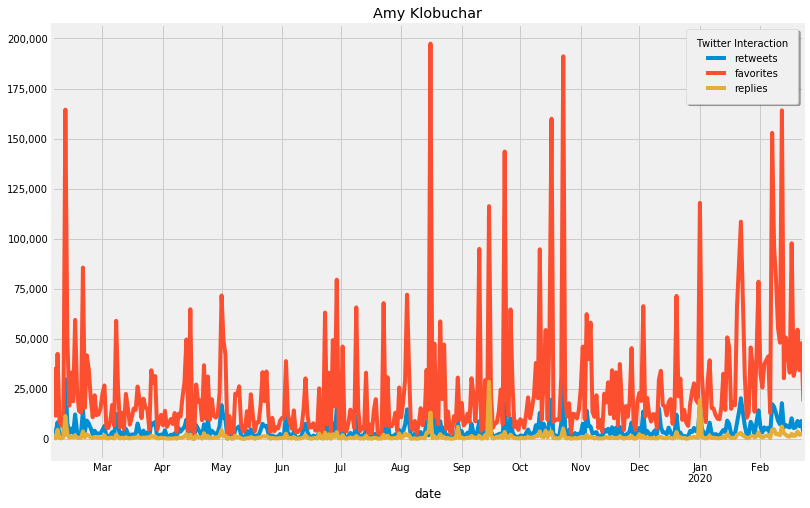

In [33]:
retweet_fav_reply_plot(bernie_sentiment, 'Bernie Sanders', rate='D', asof=bern_ann)
retweet_fav_reply_plot(joe_sentiment, 'Joe Biden', rate='D', asof=joe_ann)
retweet_fav_reply_plot(pete_sentiment, 'Pete Buttigieg', rate='D', asof=pete_ann)
retweet_fav_reply_plot(warren_sentiment, 'Elizabeth Warren', rate='D', asof=warren_ann)
retweet_fav_reply_plot(amy_sentiment, 'Amy Klobuchar', rate='D', asof=amy_ann)

In [34]:
def election_timeperiod(df, asof=None, days_adj=7):
    cols = ['polarity','retweets', 'favorites', 'replies']
    df = df[cols]
    return df[df.index > (asof - timedelta(days=days_adj))]

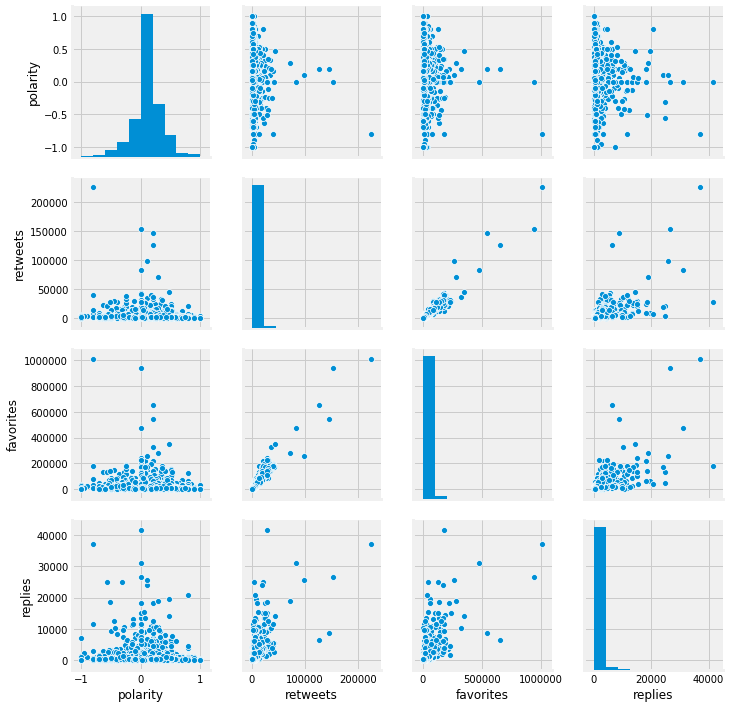

In [35]:
sns.pairplot(election_timeperiod(bernie_sentiment, bern_ann))
plt.show()

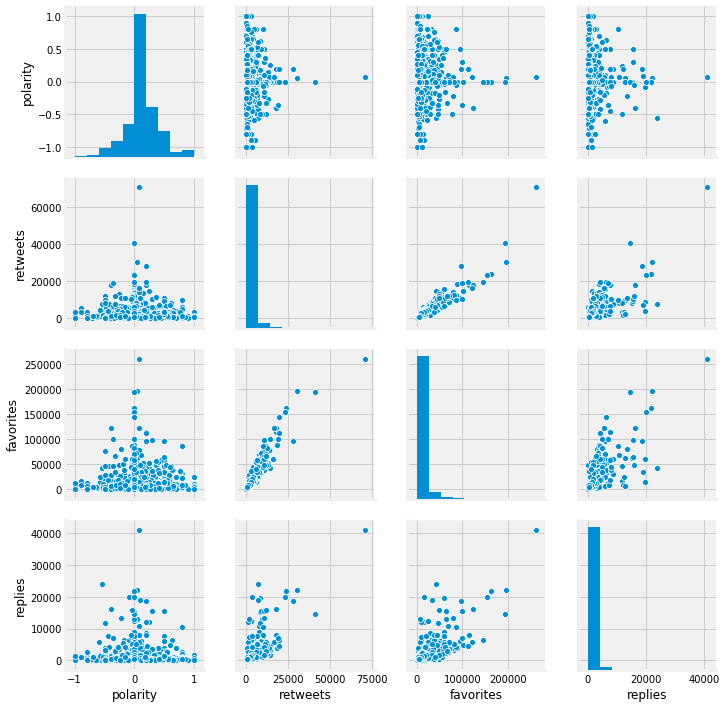

In [36]:
sns.pairplot(election_timeperiod(joe_sentiment, joe_ann))
plt.show()

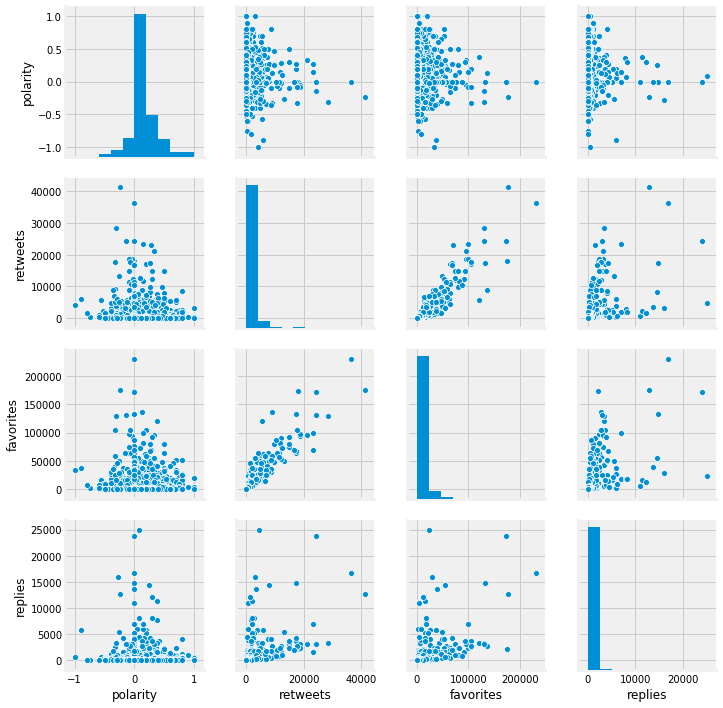

In [37]:
sns.pairplot(election_timeperiod(pete_sentiment, pete_ann))
plt.show()

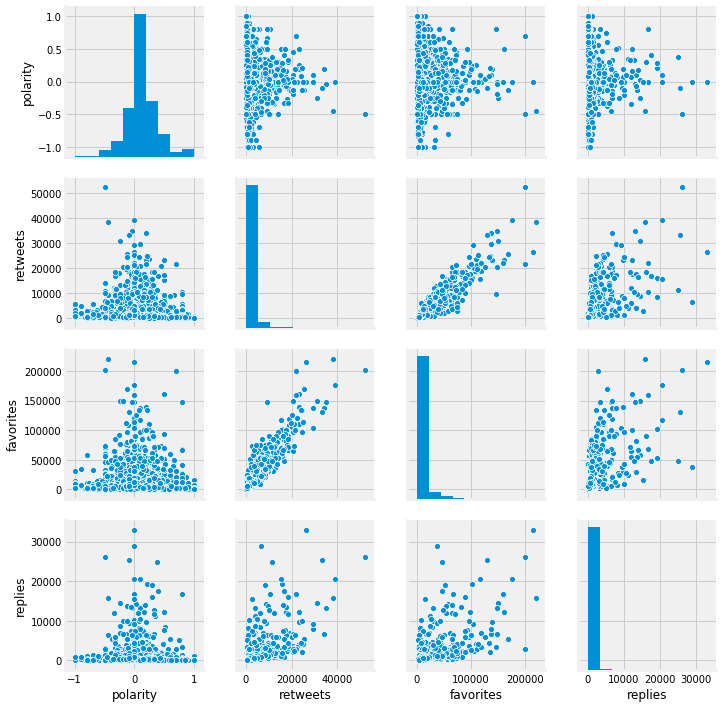

In [38]:
sns.pairplot(election_timeperiod(warren_sentiment, warren_ann))
plt.show()

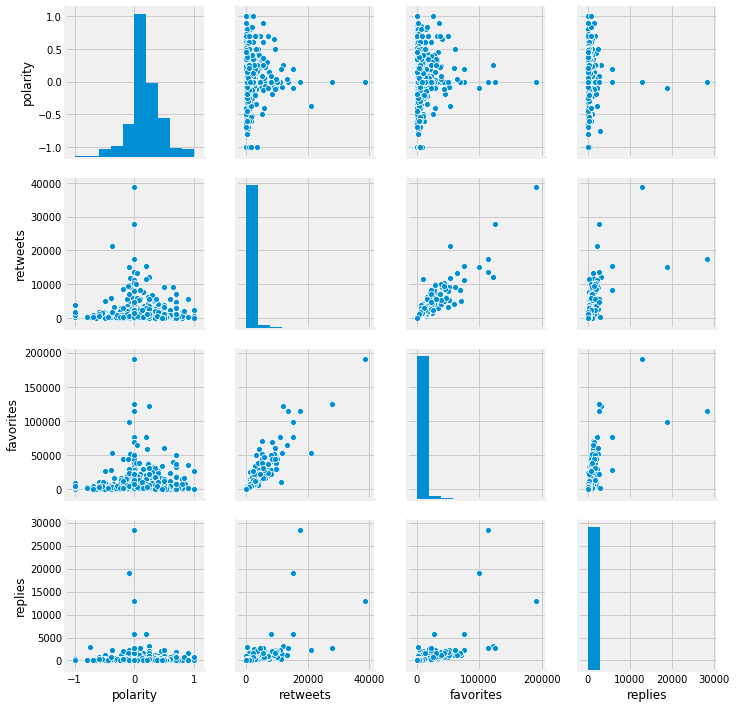

In [39]:
sns.pairplot(election_timeperiod(amy_sentiment, amy_ann))
plt.show()

In [40]:
def noun_phrase_wordlist(df):
    wordlist = pd.DataFrame()
    for t in df['text']:
        tx = TextBlob(t)
        l = list(tx.noun_phrases)
        if len(l)!=0:
            wordlist = wordlist.append(l)
    return wordlist

In [43]:
bern_wordlist = noun_phrase_wordlist(bernie_sentiment)
bern_allwords = bern_wordlist.groupby(0).size()

In [44]:
joe_wordlist = noun_phrase_wordlist(joe_sentiment)
joe_allwords = joe_wordlist.groupby(0).size()

In [45]:
pete_wordlist = noun_phrase_wordlist(pete_sentiment)
pete_allwords = pete_wordlist.groupby(0).size()

In [46]:
warren_wordlist = noun_phrase_wordlist(warren_sentiment)
warren_allwords = warren_wordlist.groupby(0).size()

In [47]:
amy_wordlist = noun_phrase_wordlist(amy_sentiment)
amy_allwords = amy_wordlist.groupby(0).size()

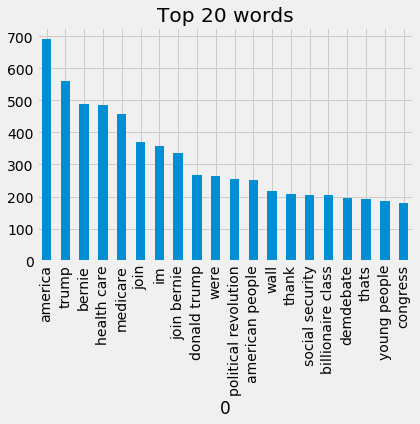

In [54]:
top20allword = bern_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

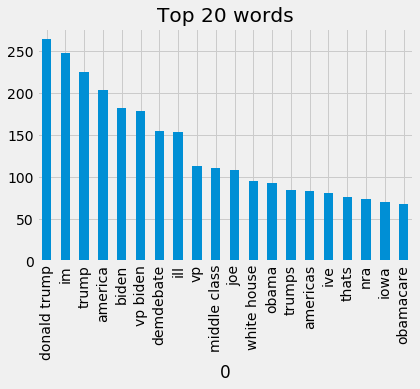

In [55]:
top20allword = joe_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

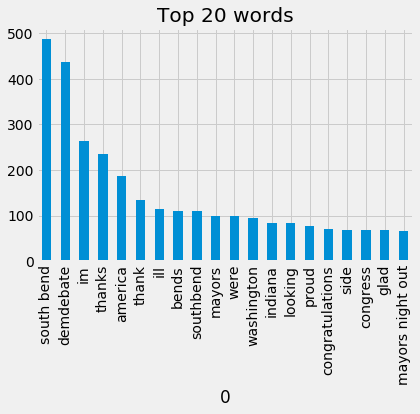

In [56]:
top20allword = pete_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

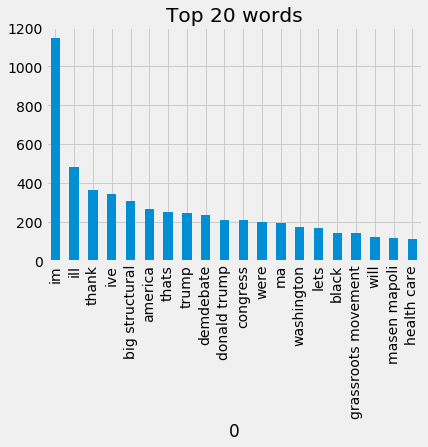

In [52]:
top20allword = warren_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

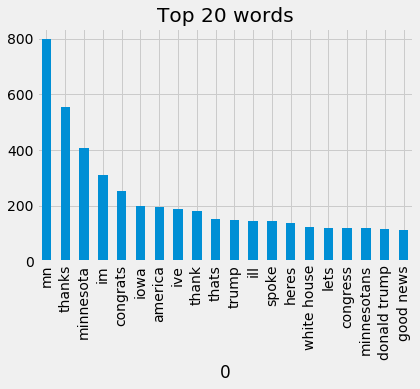

In [53]:
top20allword = amy_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

In [ ]:
wordlist2 = pd.DataFrame()
for t in bernie_sentiment['text']:
    tx = TextBlob(t)
    l = list(tx.words.lemmatize())
    if len(l)!=0:
        wordlist2 = wordlist2.append(l,ignore_index=True)

In [ ]:
allword2 = wordlist2.groupby(0).size()

In [ ]:
top20allword2 = allword2.sort_values(0,ascending=False).head(20)
top20allword2.plot(kind='bar',title='Top 20 words')
plt.show()

In [ ]:
bernie_sentiment[['text', 'polarity', 'wk_name']]

In [ ]:
bern_features = data_filter(bernie_sentiment, asof=bern_ann - timedelta(days=7))

In [ ]:
bern_features

In [ ]:
bernie_sentiment